In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
from IPython.display import display

from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


gpus = tf.config.list_physical_devices('GPU')

print(f"TensorFlow Version: {tf.__version__}")
if gpus:
    print(f"✅ Success! GPU Detected: {gpus}")
else:
    print("❌ Warning: No GPU detected.")

2026-01-03 13:03:17.799057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767445397.950525      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767445398.000455      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767445398.363937      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767445398.363981      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767445398.363984      24 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
✅ Success! GPU Detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Block 2: Load Data
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape:  {test_df.shape}")

train_df.head()

Train set shape: (42000, 785)
Test set shape:  (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Block 3: Separate Labels and Features

Y_train = train_df["label"]
X_train = train_df.drop(labels=["label"], axis=1)
X_test = test_df

print(f"X_train shape (Pixels): {X_train.shape}")
print(f"Y_train shape (Labels): {Y_train.shape}")

X_train shape (Pixels): (42000, 784)
Y_train shape (Labels): (42000,)


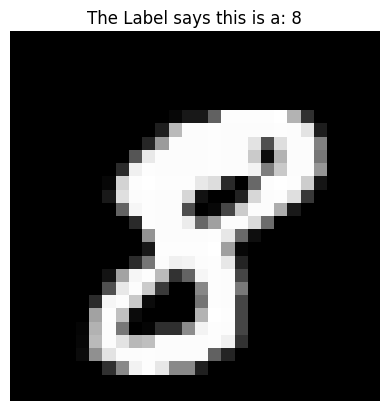

In [4]:
# Block 4: Visualize one sample
index = 10  # You can change this number to see different digits

image_data = X_train.iloc[index].values.reshape(28, 28)

plt.imshow(image_data, cmap='gray')
plt.title(f"The Label says this is a: {Y_train[index]}")
plt.axis("off")
plt.show()

In [5]:
# Block 5: Normalize and Reshape

X_train = X_train / 255.0
X_test = X_test / 255.0

# -1 means "automatically calculate this number based on the other dimensions" (so it keeps all 42,000 rows)
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

print(f"New X_train shape: {X_train.shape}")
print(f"New X_test shape:  {X_test.shape}")

New X_train shape: (42000, 28, 28, 1)
New X_test shape:  (28000, 28, 28, 1)


In [6]:
# Block 6: Label Encoding & Splitting

Y_train = to_categorical(Y_train, num_classes = 10)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

print(f"Training Images (X_train): {X_train.shape}")
print(f"Training Labels (Y_train): {Y_train.shape}")
print(f"Validation Images (X_val): {X_val.shape}")
print(f"Validation Labels (Y_val): {Y_val.shape}")

Training Images (X_train): (37800, 28, 28, 1)
Training Labels (Y_train): (37800, 10)
Validation Images (X_val): (4200, 28, 28, 1)
Validation Labels (Y_val): (4200, 10)


In [7]:
# Block 7: Build the CNN Model

model = keras.Sequential([
    
    # --- Block A: Find Simple Patterns (Edges, Lines) ---
    layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.25),


    # --- Block B: Find Complex Patterns (Curves, Loops) ---
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'),
    layers.BatchNormalization(),  # <--- NEW
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'),
    layers.BatchNormalization(),  # <--- NEW
    
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.25),


    # --- Block C: Classification (Decision Making) ---
    layers.Flatten(),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(10, activation="softmax")
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1767445414.185319      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889,322 (3.39 MB)

 Trainable params: 888,426 (3.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
# Block 8: Compile the Model

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

print("✅ Model compiled successfully.")

✅ Model compiled successfully.


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [9]:
# Block 9: Data Augmentation

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

print("✅ Data Augmentation generator created.")

✅ Data Augmentation generator created.


In [10]:
# Block 10: Callbacks (Learning Rate & Checkpointing)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

checkpoint = ModelCheckpoint(
    filepath="best_digit_model.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

print("✅ Callbacks defined: LR Reduction and Checkpointing.")

✅ Callbacks defined: LR Reduction and Checkpointing.


In [11]:
# Block 11: Train the Model

epochs = 30
batch_size = 86

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs = epochs,
    validation_data = (X_val, Y_val),
    verbose = 2,
    steps_per_epoch = X_train.shape[0] // batch_size,
    
    callbacks=[learning_rate_reduction, checkpoint] 
)

print("✅ Training complete!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1767445418.109370      65 service.cc:152] XLA service 0x7c4858005fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767445418.109415      65 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767445418.610863      65 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767445423.770288      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.93095, saving model to best_digit_model.keras
439/439 - 24s - 54ms/step - accuracy: 0.9122 - loss: 0.2818 - val_accuracy: 0.9310 - val_loss: 0.2163 - learning_rate: 1.0000e-03
Epoch 2/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.93095
439/439 - 0s - 755us/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 0.9310 - val_loss: 0.2048 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy improved from 0.93095 to 0.98119, saving model to best_digit_model.keras
439/439 - 10s - 23ms/step - accuracy: 0.9698 - loss: 0.0989 - val_accuracy: 0.9812 - val_loss: 0.0623 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy improved from 0.98119 to 0.98238, saving model to best_digit_model.keras
439/439 - 0s - 925us/step - accuracy: 0.9767 - loss: 0.0639 - val_accuracy: 0.9824 - val_loss: 0.0533 - learning_rate: 1.0000e-03
Epoch 5/30

Epoch 5: val_accuracy improved from 0.98238 to 0.99071, saving model to best_digit_model.keras
439/439 - 10s - 23ms/step - accuracy: 0.9765 - loss: 0.0782 - val_accuracy: 0.9907 - val_loss: 0.0343 - learning_rate: 1.0000e-03
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.99071
439/439 - 0s - 734us/step - accuracy: 0.9884

✅ Loaded best weights from file.


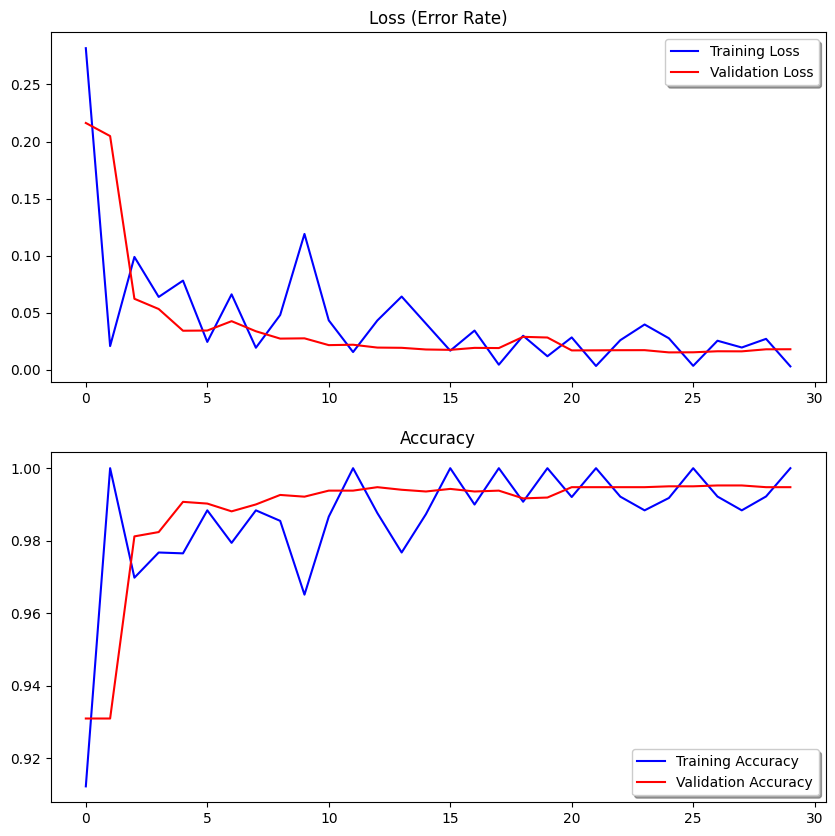

In [12]:
# Block 12: Evaluate Performance (Graphs)

model.load_weights("best_digit_model.keras")
print("✅ Loaded best weights from file.")

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# 1. Loss Plot (Lower is better)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("Loss (Error Rate)")

# 2. Accuracy Plot (Higher is better)
ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Accuracy")

plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


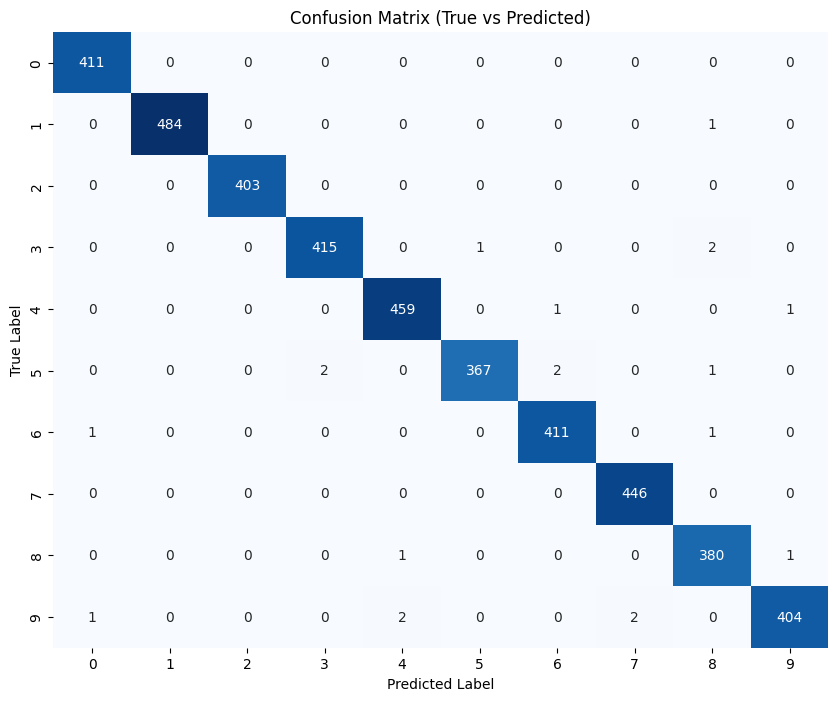

❌ Total Errors: 20 out of 4200


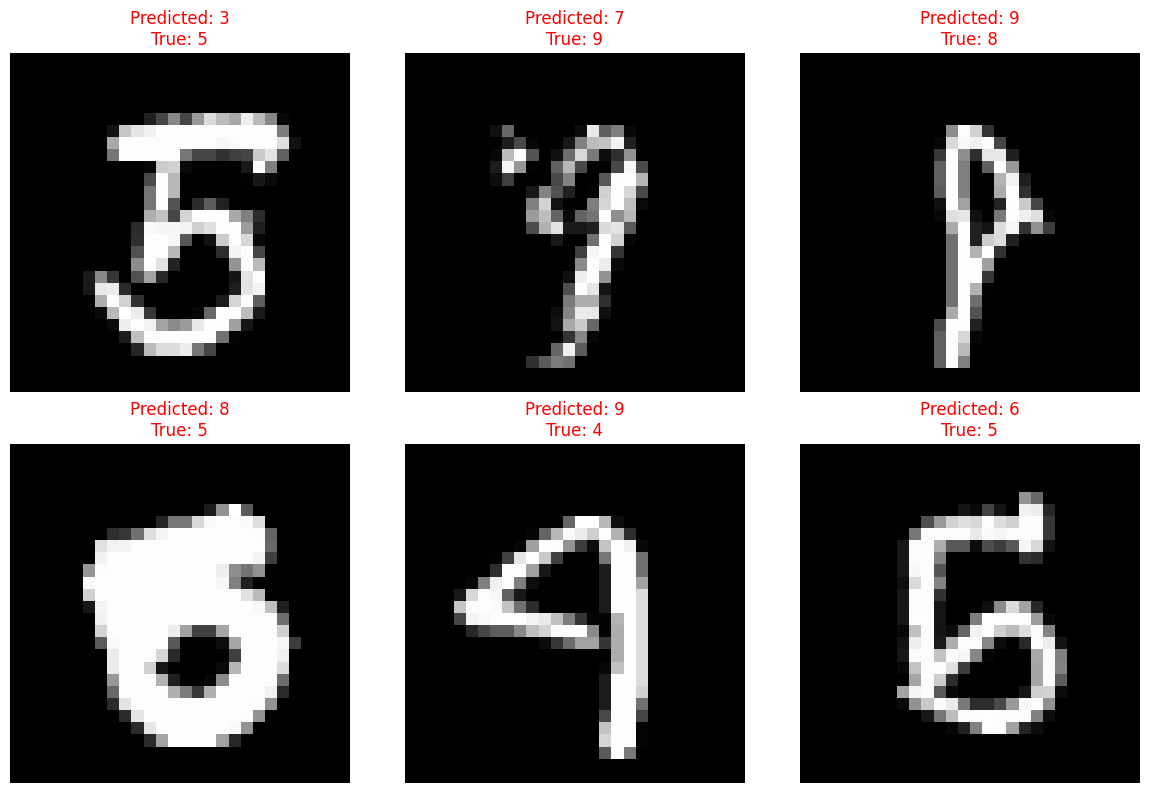

In [13]:
# Block 12.5: Deep Dive Evaluation

Y_true = np.argmax(Y_val, axis=1)
Y_pred_probs = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)

cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (True vs Predicted)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_probs_errors = Y_pred_probs[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted: {}\nTrue: {}".format(pred_errors[error], obs_errors[error]), color='red')
            ax[row,col].axis('off')
            n += 1
    plt.tight_layout()
    plt.show()

print(f"❌ Total Errors: {len(Y_pred_classes_errors)} out of {len(X_val)}")
if len(Y_pred_classes_errors) > 0:
    display_errors(range(6), X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [14]:
# Block 13: Interactive Prediction Widget

def view_prediction(index):
    img = X_test[index]
    
    img_for_model = img.reshape(1, 28, 28, 1)
    
    pred_prob = model.predict(img_for_model, verbose=0)
    pred_label = np.argmax(pred_prob)
    confidence = np.max(pred_prob) * 100
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img.reshape(28, 28), cmap='gray')
    
    color = 'blue' if confidence > 90 else 'red'
    
    plt.title(f"Model Prediction: {pred_label}\nConfidence: {confidence:.2f}%", 
              color=color, fontsize=14)
    plt.axis('off')
    plt.show()

print("👇 Move the slider to see predictions on the Test Set:")
slider = widgets.IntSlider(value=0, min=0, max=len(X_test)-1, step=1, description='Image ID:')
widgets.interactive(view_prediction, index=slider)

👇 Move the slider to see predictions on the Test Set:


interactive(children=(IntSlider(value=0, description='Image ID:', max=27999), Output()), _dom_classes=('widget…

🧠 Visualizing the internal layers for a test image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Layer: conv2d | Grid shape: 28x28 | Filters: 32


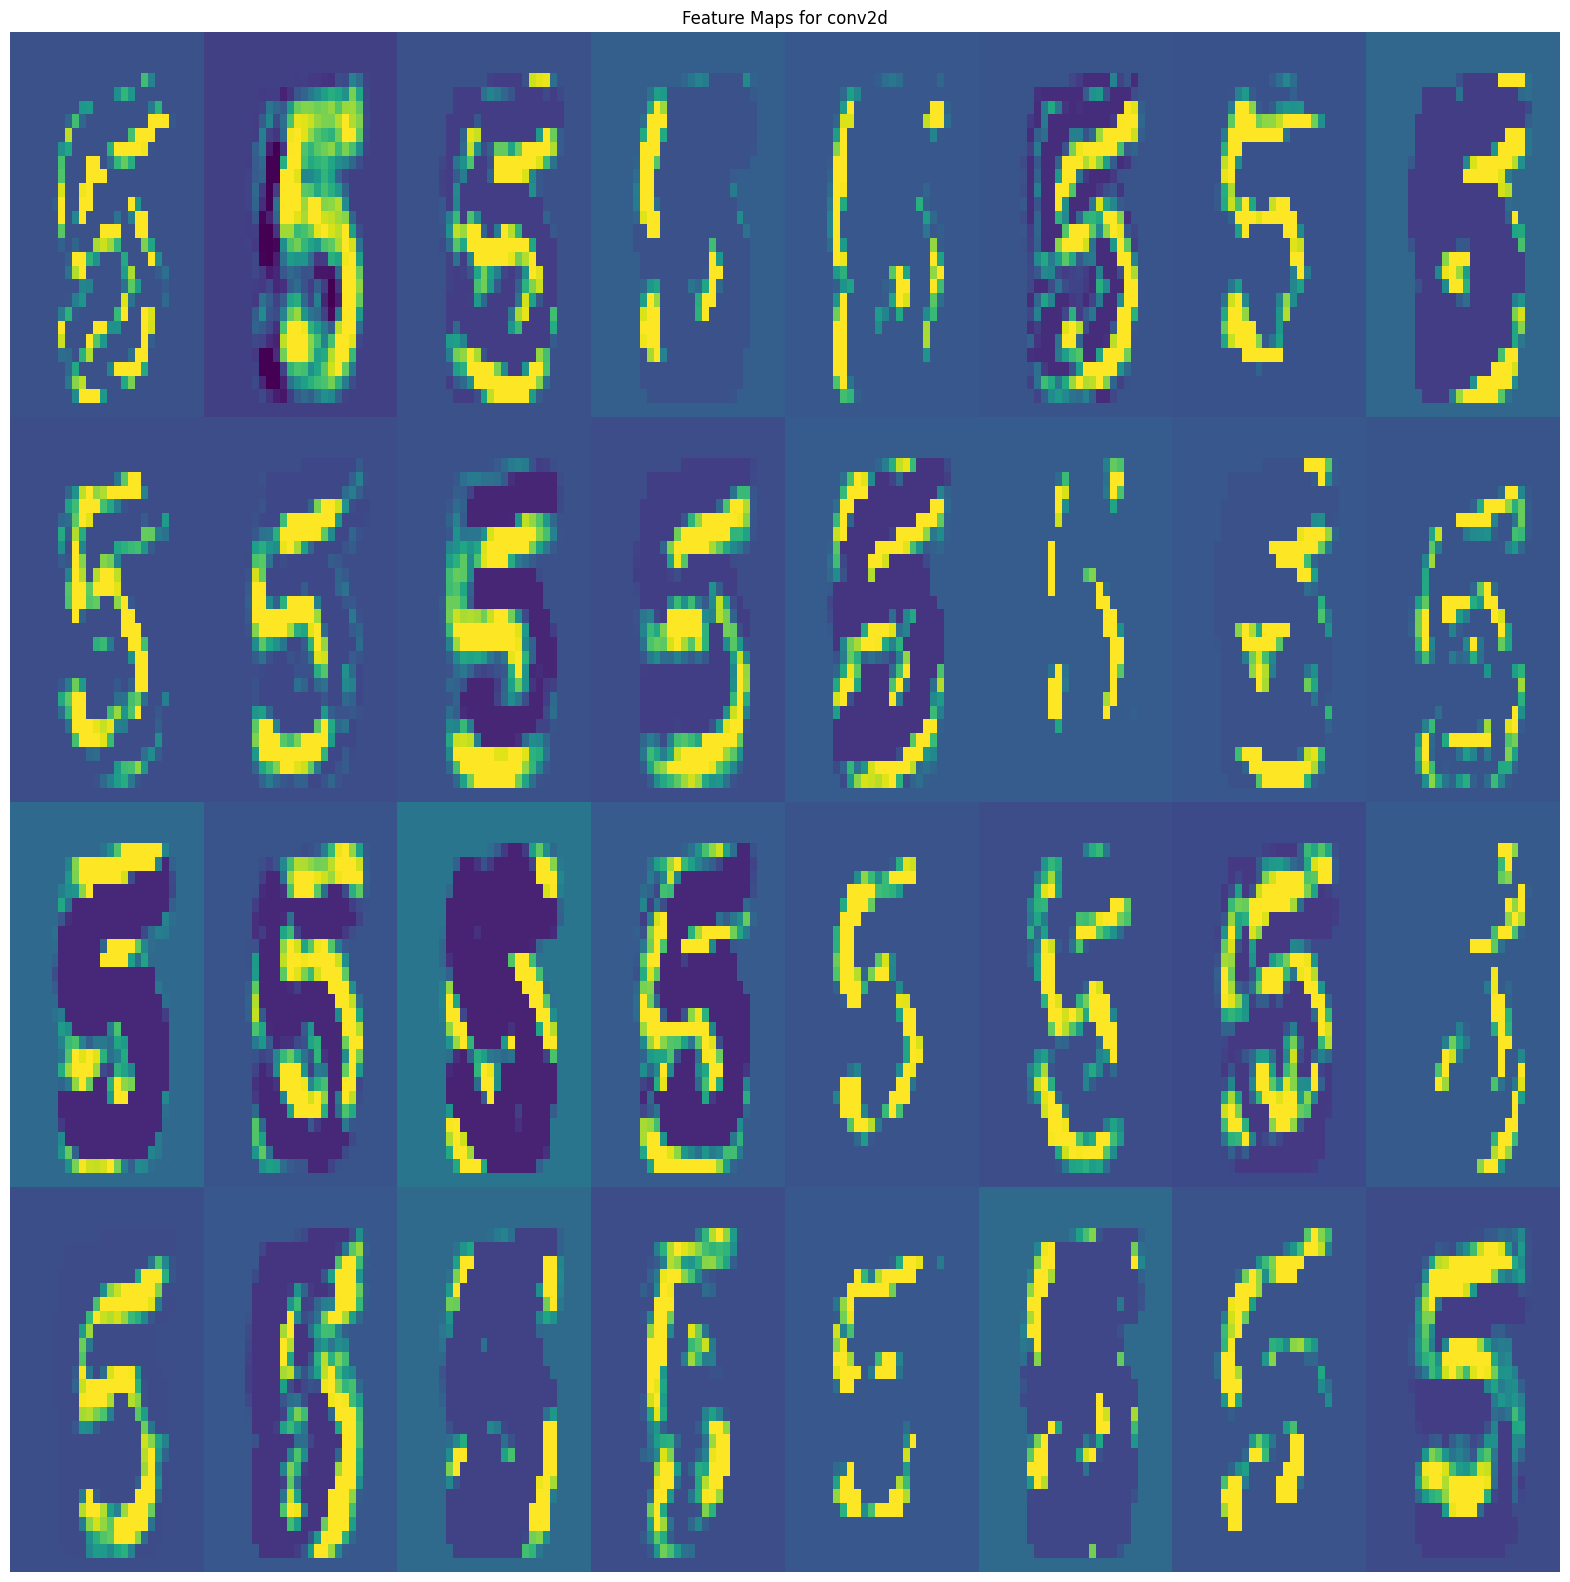

Layer: conv2d_1 | Grid shape: 28x28 | Filters: 32


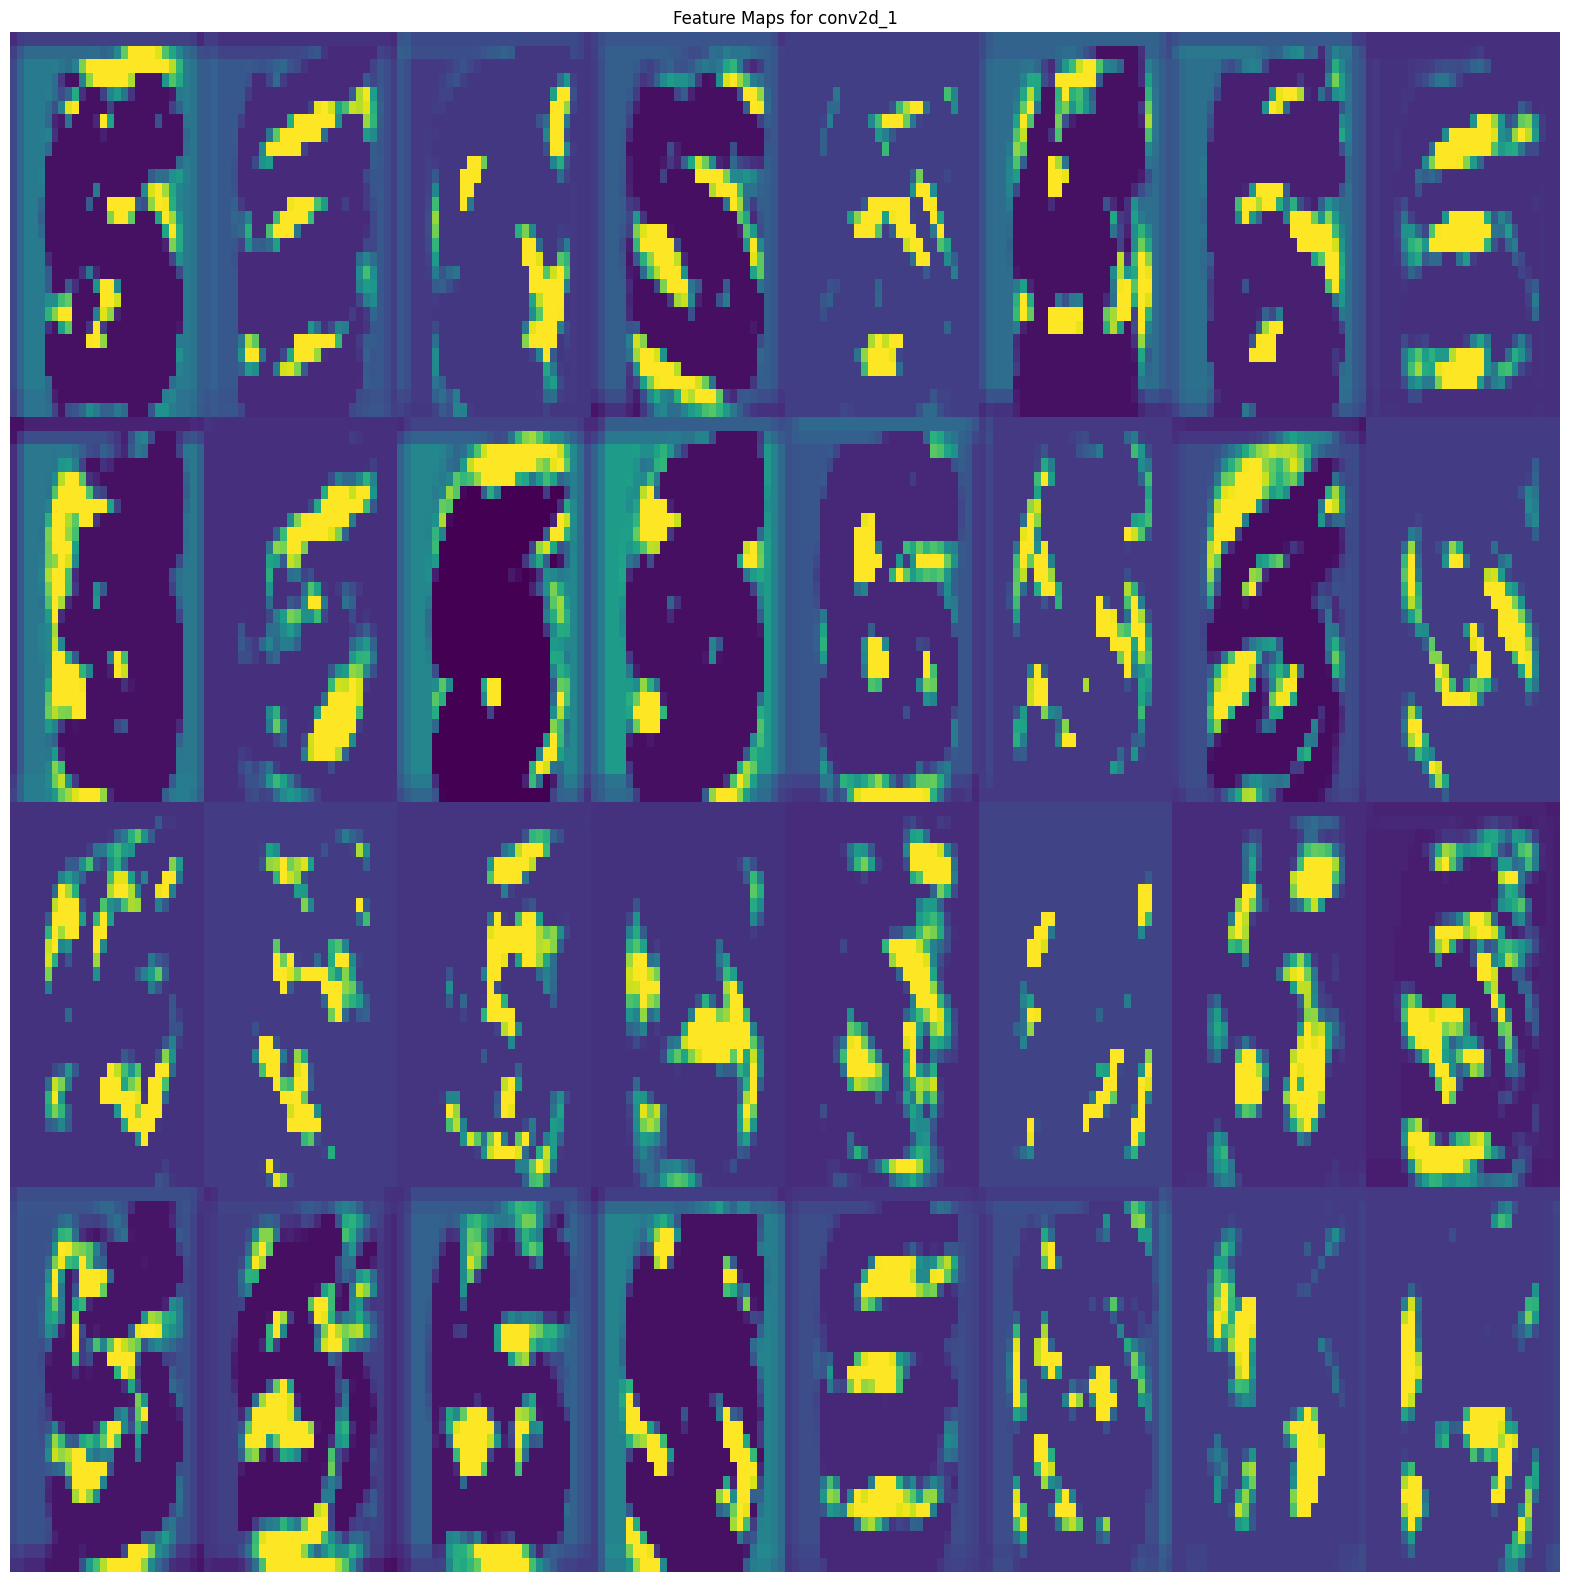

Layer: conv2d_2 | Grid shape: 14x14 | Filters: 64


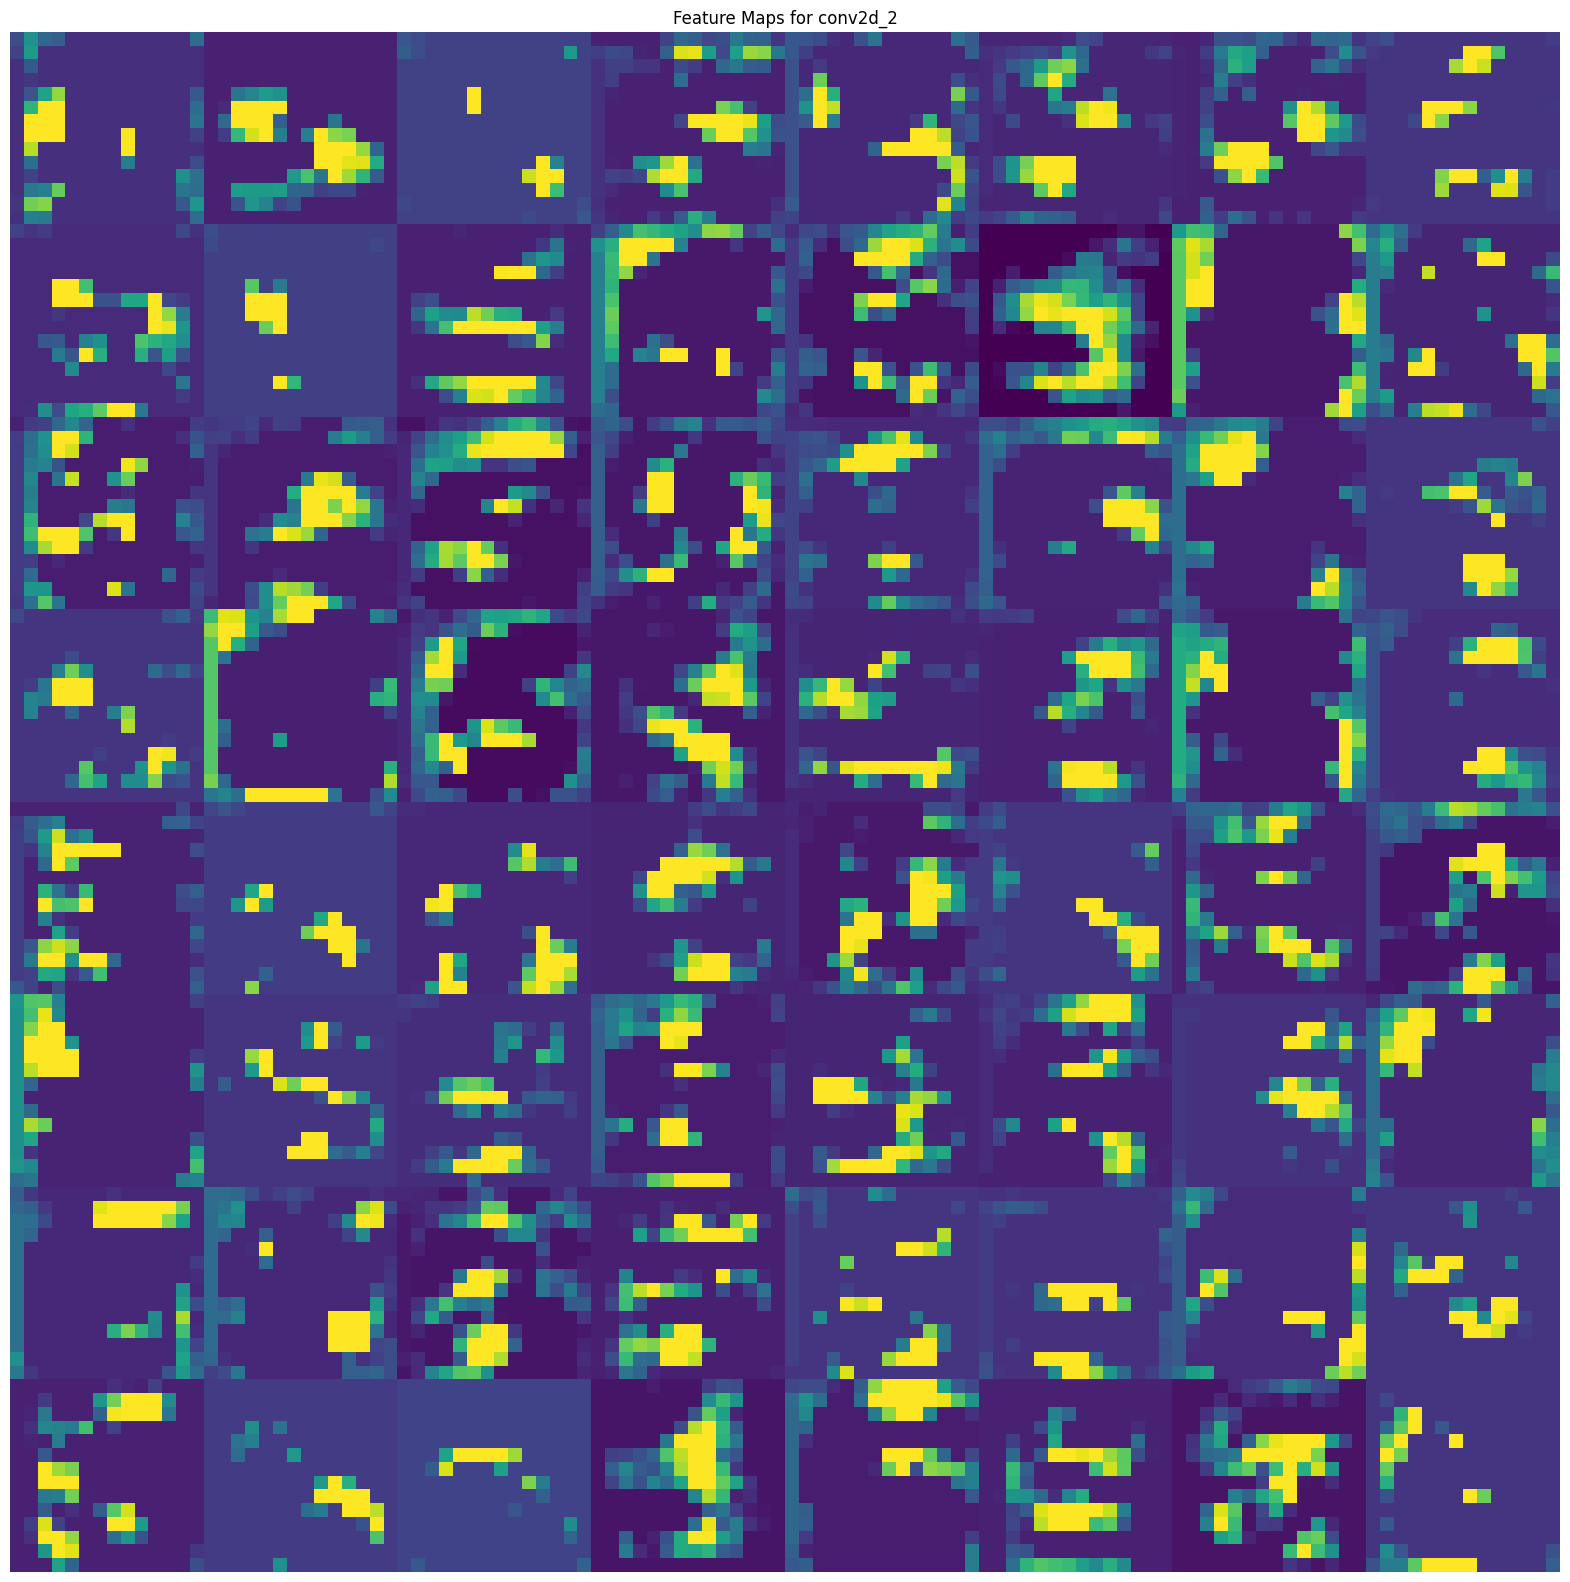

Layer: conv2d_3 | Grid shape: 14x14 | Filters: 64


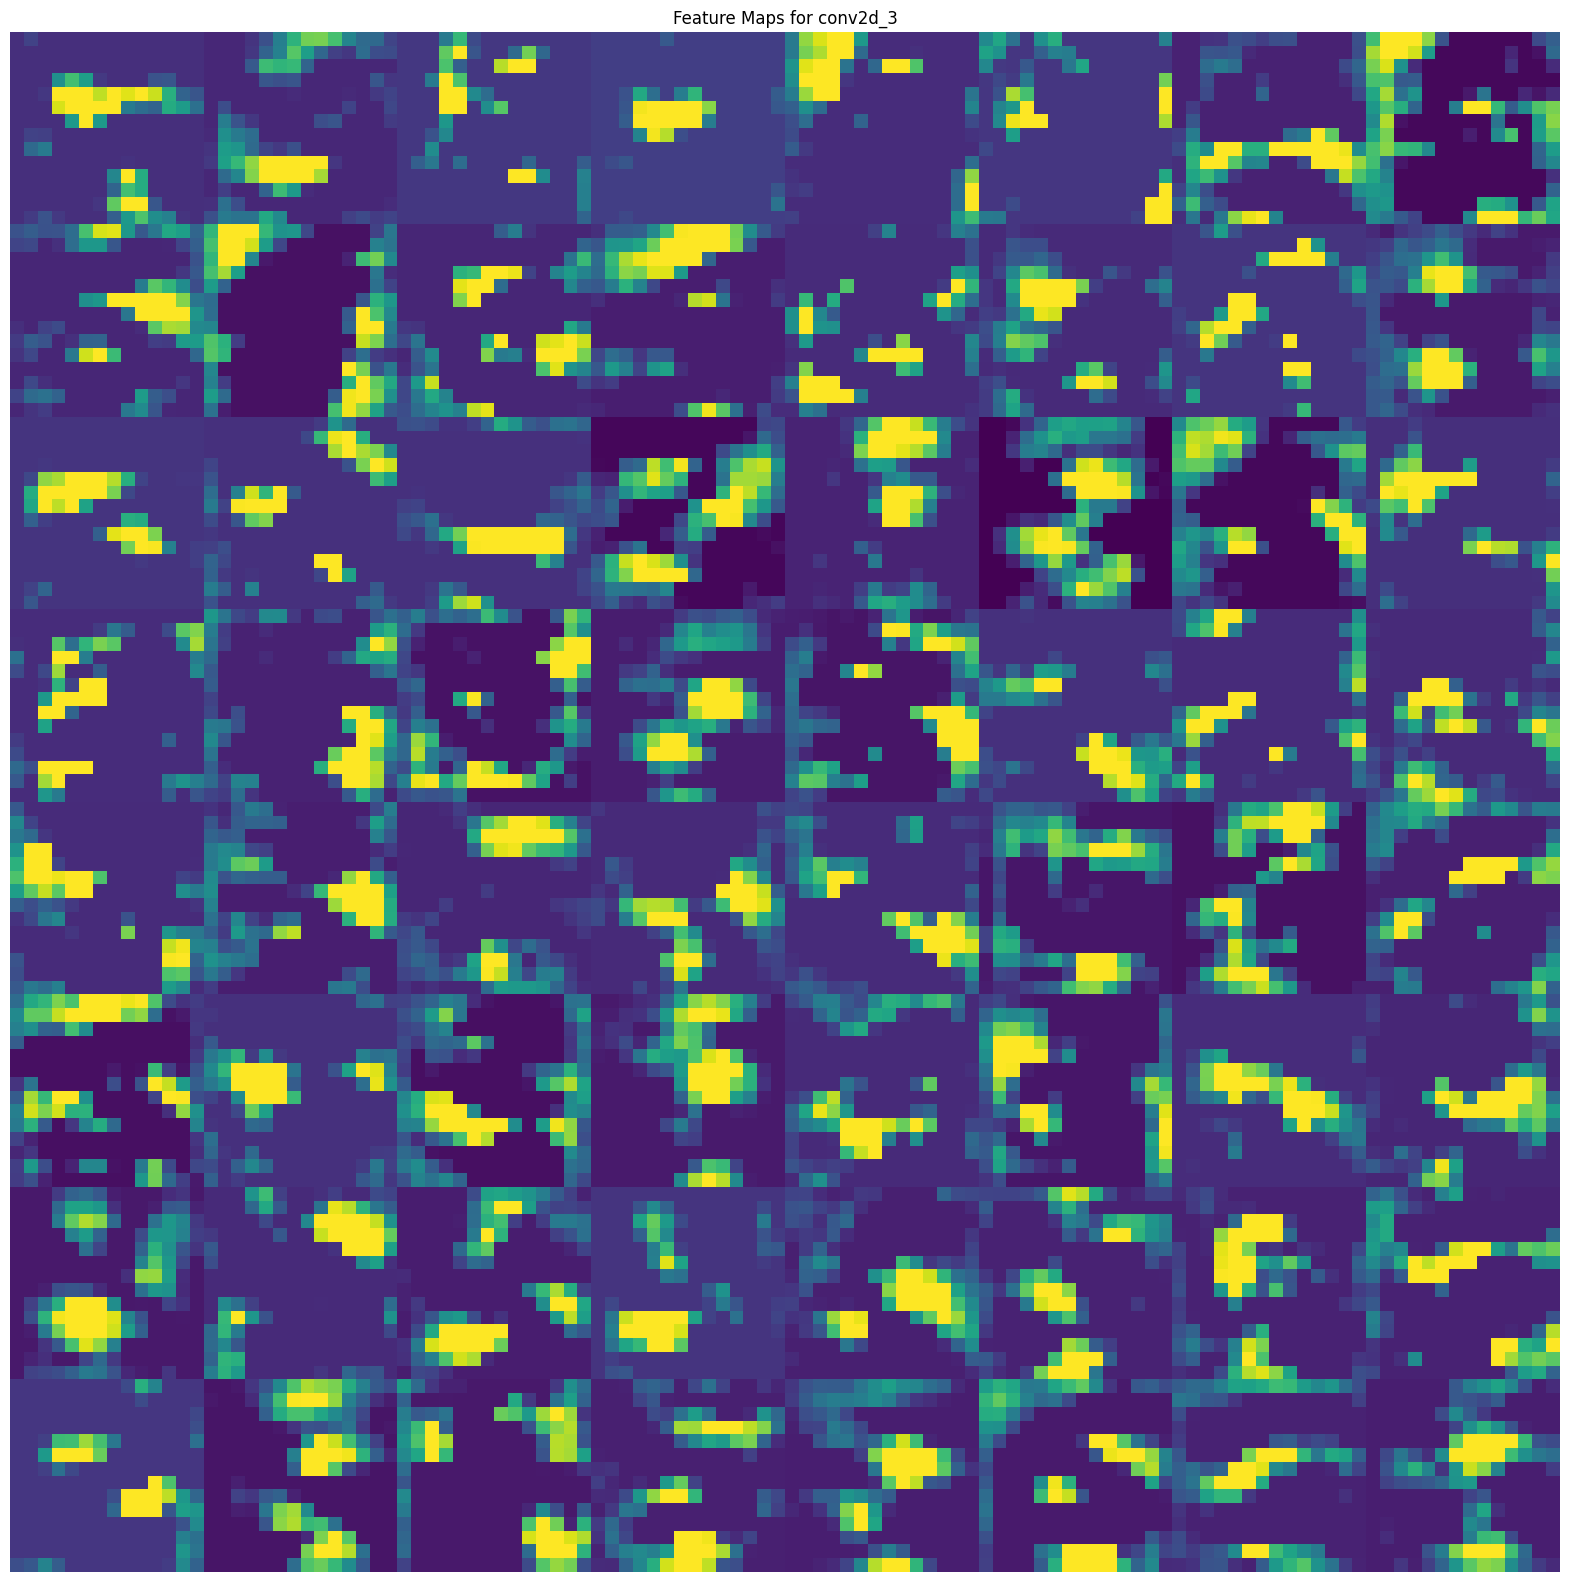

In [15]:
# Block 14: Visualize Feature Maps (CNN "Brain Scan")

def visualize_feature_maps(model, image_index):
    img_input = keras.Input(shape=(28, 28, 1))
    
    x = img_input
    layer_outputs = []
    layer_names = []
    
    for layer in model.layers:
        x = layer(x) 
        
        if 'conv2d' in layer.name:
            layer_outputs.append(x)
            layer_names.append(layer.name)
    
    activation_model = keras.models.Model(inputs=img_input, outputs=layer_outputs)
    
    img = X_test[image_index].reshape(1, 28, 28, 1)
    
    activations = activation_model.predict(img)
    
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        
        n_cols = n_features // 8 
        print(f"Layer: {layer_name} | Grid shape: {size}x{size} | Filters: {n_features}")
        
        display_grid = np.zeros((size * n_cols, 8 * size))
        
        for col in range(n_cols):
            for row in range(8):
                channel_image = layer_activation[0, :, :, col * 8 + row]
                
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std() + 1e-5
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale * n_features))
        plt.title(f"Feature Maps for {layer_name}")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.show()

print("🧠 Visualizing the internal layers for a test image...")
visualize_feature_maps(model, 10)

In [16]:
# Block 15: Predict results

results = model.predict(X_test)

results = np.argmax(results, axis = 1)

results = pd.Series(results, name="Label")

print("✅ Predictions generated.")
print(f"First 5 predictions: {results.head().values}")

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Predictions generated.
First 5 predictions: [2 0 9 0 3]


In [17]:
# Block 16: Generate Submission CSV

submission = pd.DataFrame({
    "ImageId": range(1, len(results) + 1),
    "Label": results
})

submission.to_csv("submission.csv", index=False)

print("✅ Submission file saved")
print("Here are the first few rows:")
print(submission.head())

✅ Submission file saved
Here are the first few rows:
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
❌ Total Errors in Validation Set: 20 out of 4200


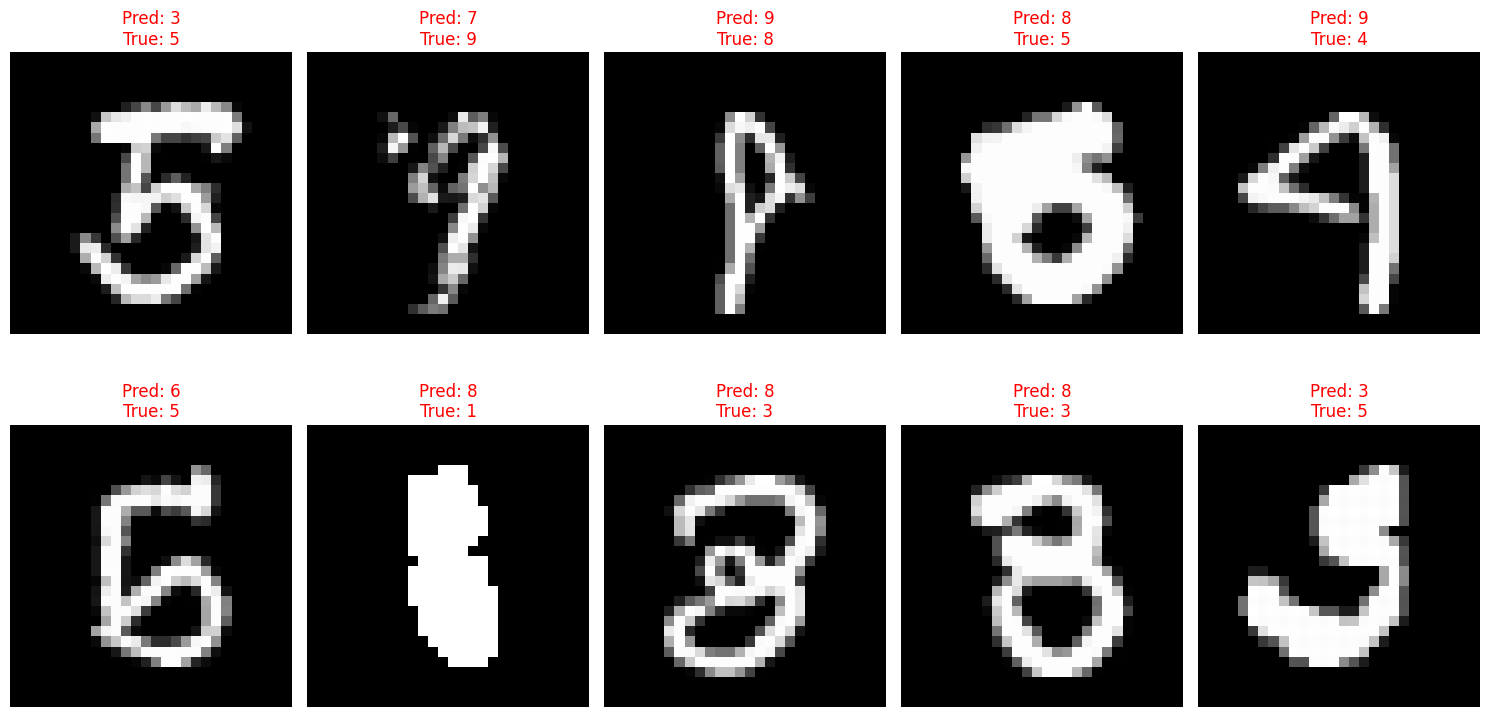

In [18]:
# Block 17: Error Analysis (Visualizing Mistakes)

y_val_true = np.argmax(Y_val, axis=1)
val_preds = np.argmax(model.predict(X_val), axis=1)

errors = (val_preds != y_val_true)
error_indices = np.where(errors)[0]

print(f"❌ Total Errors in Validation Set: {len(error_indices)} out of {len(X_val)}")

plt.figure(figsize=(15, 8))
for i, idx in enumerate(error_indices[:10]):
    plt.subplot(2, 5, i+1)
    
    plt.imshow(X_val[idx].reshape(28, 28), cmap='gray')
    
    plt.title(f"Pred: {val_preds[idx]}\nTrue: {y_val_true[idx]}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()